## Setup Kernel and requiered dependecies

In [1]:
!pip install --disable-pip-version-check \
  torch==2.8.0 \
  torchdata==0.11.0 --quiet

!pip install \
  transformers==4.44.2 \
  # datasets==2.11.0 \
  rouge_score==0.1.2 \
  loralib==0.1.1 \
  peft==0.3.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.0
    Uninstalling tokenizers-0.22.0:
      Successfully uninstalled tokenizers-0.22.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1


In [2]:
!pip install awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9.1
    Uninstalling rsa-4.9.1:
      Successfully uninstalled rsa-4.9.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.


In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00


In [4]:
!pip install --upgrade datasets==4.1.0
!pip install "pyarrow>=14.0.0,<20.0.0" --force-reinstall


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.4/503.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 25.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 13.2 MB/s eta 0:0

In [5]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.1.0
    Uninstalling sentence-transformers-5.1.0:
      Successfully uninstalled sentence-transformers-5.1.0


In [6]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer, T5ForConditionalGeneration
from sentence_transformers import SentenceTransformer
import torch
import time
import pandas as pd
import numpy as np
import torch.nn as nn
from datasets import load_dataset
from sentence_transformers import SentenceTransformer


## Load dataset and LLM

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:

my_dataset = "/content/drive/MyDrive/file_description.jsonl"

dataset = load_dataset(
    "json",
    data_files=my_dataset,
    split={
        "train": "train[:85%]",
        "validation": "train[85%:95%]",
        "test": "train[95%:]"
    }
)

dataset


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'filename', 'file_desc'],
        num_rows: 1707
    })
    validation: Dataset({
        features: ['id', 'filename', 'file_desc'],
        num_rows: 201
    })
    test: Dataset({
        features: ['id', 'filename', 'file_desc'],
        num_rows: 100
    })
})

# Load Model

In [9]:
model_name='google/flan-t5-small'
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Tokenizer + external lexical model

In [10]:
lex_model = SentenceTransformer("all-MiniLM-L6-v2")

embedding_dim = lex_model.get_sentence_embedding_dimension()  # 384
print("Lexical embedding dim:", embedding_dim)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Lexical embedding dim: 384


# Preprocessing

In [11]:
from transformers import T5ForConditionalGeneration, T5Config

config = T5ForConditionalGeneration.from_pretrained(model_name).config
hidden_size = config.d_model  # 512 for flan-t5-small
proj_layer = nn.Linear(embedding_dim, hidden_size)

# Show internal dimensions
print("Hidden size:", config.d_model)
print("Number of layers:", config.num_layers)
print("Number of attention heads:", config.num_heads)
print("Feed-forward size:", config.d_ff)


Hidden size: 512
Number of layers: 8
Number of attention heads: 6
Feed-forward size: 1024


## We generate lexical embeddings and tokenize the prompts.

In [12]:
def tokenize_function(example):
    filename = example["filename"]
    file_desc = example["file_desc"]

    # --- Embedding lexical ---
    filename_embedding = torch.tensor(lex_model.encode(filename)).float()
    filename_proj = proj_layer(filename_embedding)
    filename_proj = filename_proj / filename_proj.norm()  # normalisation

    # --- Prompt ---
    prompt = f"""
Given the following filename, generate a short description of what the file is likely about.

Filename: {filename}

Description:
"""
    tokenized_inputs = tokenizer(prompt, padding="max_length", truncation=True, max_length=128)
    tokenized_labels = tokenizer(file_desc, padding="max_length", truncation=True, max_length=128)

    tokenized_inputs["labels"] = tokenized_labels["input_ids"]
    tokenized_inputs["lexical_embeds"] = filename_proj.detach().numpy().astype("float32").tolist()
    return tokenized_inputs



## Application sur le dataset

In [13]:
tokenized_datasets = dataset.map(tokenize_function, batched=False)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'filename', 'file_desc'])

print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Map:   0%|          | 0/1707 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Training: (1707, 4)
Validation: (201, 4)
Test: (100, 4)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'lexical_embeds'],
        num_rows: 1707
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'lexical_embeds'],
        num_rows: 201
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'lexical_embeds'],
        num_rows: 100
    })
})


# Pre-processing Evaluation

## 1- Consistency check :
measure the consistency between each filename and its lexical_embeds

In [14]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

In [15]:
# --- Projection to Flan-T5 ---
embedding_dim = embedding_dim           # MIniLM dimension

# --- Fonction cosine similarity ---
def cosine(a, b):
    return cosine_similarity(a.reshape(1,-1), b.reshape(1,-1))[0,0]

# --- Test consistency and discrimination ---
same_sims = []
diff_sims = []

for split in ["train", "validation", "test"]:
    dataset_split = dataset[split]

    for ex in dataset_split:
        filename = ex["filename"]
        emb_orig = torch.tensor(lex_model.encode(filename)).float() # Direct embedding
        emb_proj = proj_layer(emb_orig).detach().numpy()   # Projected embedding (lexical_embeds)

        # similarity to himself
        same_sims.append(cosine(emb_proj, emb_proj))

        # similarity with a random filename
        other_ex = random.choice(dataset_split)
        emb_other = torch.tensor(lex_model.encode(other_ex["filename"])).float()
        emb_other_proj = proj_layer(emb_other).detach().numpy()
        diff_sims.append(cosine(emb_proj, emb_other_proj))

print("Average similarity same filename :", np.mean(same_sims))
print("Average similarity filename different :", np.mean(diff_sims))

Average similarity same filename : 1.0
Average similarity filename different : 0.64452606


## 2- Visualisation :
t-SNE or UMAP to check if semantically close filenames cluster together.

In [16]:
sample = dataset["train"][:200]  # returns a dict of lists
sample_list = [{k: v[i] for k, v in sample.items()} for i in range(len(sample['filename']))]

embeds = np.array([
    proj_layer(torch.tensor(lex_model.encode(ex["filename"])).float()).detach().numpy()
    for ex in sample_list
])
filenames = [ex["filename"] for ex in sample_list]



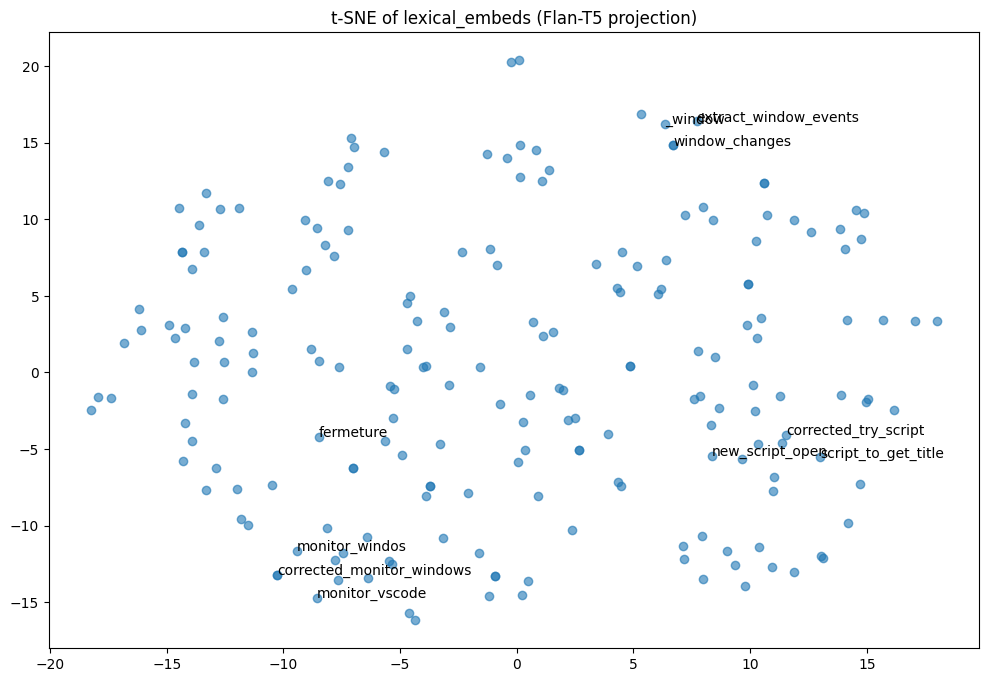

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeds)

plt.figure(figsize=(12,8))
plt.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.6)
for i in range(10):
    plt.annotate(filenames[i], (emb_2d[i,0], emb_2d[i,1]))
plt.title("t-SNE of lexical_embeds (Flan-T5 projection)")
plt.show()


# Filename disruption test

In [18]:
filename = "extract_window_events"
filename_mod = "extract_window_logs"

emb_orig = proj_layer(torch.tensor(lex_model.encode(filename)).float()).detach().numpy()
emb_mod = proj_layer(torch.tensor(lex_model.encode(filename_mod)).float()).detach().numpy()

print("Similarity filename modified :", cosine(emb_orig, emb_mod))


Similarity filename modified : 0.86637294


## Merged Model

In [19]:
import torch
import torch.nn as nn
from transformers import T5ForConditionalGeneration

class T5WithFusion(nn.Module):
    def __init__(self, model_name="google/flan-t5-small", lexical_dim=512):
        """
        lexical_dim: dimension of the lexical embeddings (must match the actual size of the embeddings)
        """
        super().__init__()
        self.t5 = T5ForConditionalGeneration.from_pretrained(model_name)
        self.proj = nn.Linear(lexical_dim, self.t5.config.d_model)

    def forward(self, input_ids=None, attention_mask=None, labels=None, lexical_embeds=None, **kwargs):

        inputs_embeds = self.t5.encoder.embed_tokens(input_ids) # normal embeddings

        if lexical_embeds is not None:
            lexical_proj = self.proj(lexical_embeds.float()).to(inputs_embeds.device)

            inputs_embeds = inputs_embeds + lexical_proj.unsqueeze(1) # broadcasting on length: addition, not concat

        return self.t5(
            input_ids=None,
            attention_mask=attention_mask,
            labels=labels,
            inputs_embeds=inputs_embeds,
            **kwargs
        )


    # for generation
    def prepare_inputs_for_generation(self, input_ids, attention_mask=None, **kwargs):
        inputs = self.t5.prepare_inputs_for_generation(input_ids, attention_mask=attention_mask, **kwargs)
        if "lexical_embeds" in kwargs:
            inputs["lexical_embeds"] = kwargs["lexical_embeds"]
        return inputs

    # delegate all attributes not found
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.t5, name)


## Data Collator

In [20]:
class DataCollatorWithFusion:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        input_ids = torch.stack([torch.tensor(x["input_ids"], dtype=torch.long) for x in batch])
        attention_mask = torch.stack([torch.tensor(x["attention_mask"], dtype=torch.long) for x in batch])
        labels = torch.stack([torch.tensor(x["labels"], dtype=torch.long) for x in batch])

        # replace padding token with -100
        labels = labels.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100

        #lexical embeddings
        lexical_embeds = torch.stack([torch.tensor(x["lexical_embeds"], dtype=torch.float32) for x in batch])

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "lexical_embeds": lexical_embeds,
        }


In [21]:
from transformers import DataCollatorForSeq2Seq

collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model_name,
    label_pad_token_id=-100,  # for ignore_index
    pad_to_multiple_of=8      # to accelerate on GPU
)


In [22]:
batch = collator([tokenized_datasets["train"][i] for i in range(2)])
print("Labels:", batch["labels"][0][:50])  # must contain many tokens != -100


Labels: tensor([  94,  952, 5819,    7, 2034,   18, 3897,  984,   45,    3,    9,  358,
          42,  917,    5,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])


### Check a batch

In [23]:
collator = DataCollatorWithFusion(tokenizer)
sample_batch = [tokenized_datasets["train"][i] for i in range(2)]
batch = collator(sample_batch)

print(batch["input_ids"].shape)       # (B, L)
print(batch["attention_mask"].shape)  # (B, L)
print(batch["labels"].shape)          # (B, L)
print(batch["lexical_embeds"].shape)  # (B, D)
print(batch["labels"])                # check if -100 appears correctly

# ---- Forward testing with the merged model ----
model = T5WithFusion(model_name="google/flan-t5-small")
outputs = model(
    input_ids=batch["input_ids"],
    attention_mask=batch["attention_mask"],
    labels=batch["labels"],
    lexical_embeds=batch["lexical_embeds"],
)

print(outputs.loss)
print(outputs.logits.shape)  # (B, L, vocab_size)


torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 512])
tensor([[   94,   952,  5819,     7,  2034,    18,  3897,   984,    45,     3,
             9,   358,    42,   917,     5,     1,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -1

## Training arguments

In [24]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Training

In [25]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Gen_Desc_Model/results_full",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    fp16=False,
    report_to="none",
    remove_unused_columns=False,
    save_safetensors=False,   # disables safetensors
)


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Create trainer

In [26]:
model = T5WithFusion(model_name=model_name)
data_collator = DataCollatorWithFusion(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=collator,  # DataCollatorWithFusion
)



In [27]:
# --- Quick test of a batch before launching ---
sample_batch = [tokenized_datasets["train"][i] for i in range(2)]
batch = collator(sample_batch)
device = next(model.parameters()).device
batch = {k: v.to(device) for k, v in batch.items()}
outputs = model(**batch)
print("Loss test:", outputs.loss)
print("Logits shape:", outputs.logits.shape)


Loss test: tensor(4.4584, grad_fn=<NllLossBackward0>)
Logits shape: torch.Size([2, 128, 32128])


### --- Start training ---

In [ ]:

trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,1.760400,1.848140
2,1.445500,1.742487
3,1.278600,1.689969
4,1.178100,1.642674
5,1.004800,1.643041
6,1.086900,1.629400
7,1.070100,1.639439
8,1.057300,1.653582
9,1.029800,1.655568
10,1.008900,1.648280


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument i

TrainOutput(global_step=2140, training_loss=1.2567283193641734, metrics={'train_runtime': 21292.6211, 'train_samples_per_second': 0.802, 'train_steps_per_second': 0.101, 'total_flos': 793287728824320.0, 'train_loss': 1.2567283193641734, 'epoch': 10.0})

## Save

In [ ]:
trainer.save_model("/content/drive/MyDrive/Gen_Desc_Model/full_finetuned")
tokenizer.save_pretrained("/content/drive/MyDrive/Gen_Desc_Model/full_finetuned")


('/content/drive/MyDrive/Gen_Desc_Model/full_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/Gen_Desc_Model/full_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/Gen_Desc_Model/full_finetuned/spiece.model',
 '/content/drive/MyDrive/Gen_Desc_Model/full_finetuned/added_tokens.json',
 '/content/drive/MyDrive/Gen_Desc_Model/full_finetuned/tokenizer.json')

In [2]:
!ls -lh /content/drive/MyDrive/Gen_Desc_Model

total 16K
drwx------ 2 root root 4.0K Oct  1 01:01 full_finetuned
drwx------ 2 root root 4.0K Sep 30 14:57 results_final
drwx------ 2 root root 4.0K Sep 30 13:05 results_full
drwx------ 2 root root 4.0K Sep 30 14:26 results_peft


In [3]:
!ls -lh /content/drive/MyDrive/Gen_Desc_Model/full_finetuned

total 298M
-rw------- 1 root root 295M Oct  1 01:01 pytorch_model.bin
-rw------- 1 root root 2.5K Oct  1 01:01 special_tokens_map.json
-rw------- 1 root root 774K Oct  1 01:01 spiece.model
-rw------- 1 root root  21K Oct  1 01:01 tokenizer_config.json
-rw------- 1 root root 2.4M Oct  1 01:01 tokenizer.json
-rw------- 1 root root 5.6K Oct  1 01:01 training_args.bin


In [4]:
!ls -lh /content/drive/MyDrive/Gen_Desc_Model/results_final

total 4.0K
drwx------ 2 root root 4.0K Sep 30 14:58 checkpoint-214


In [5]:
!ls -lh /content/drive/MyDrive/Gen_Desc_Model/results_full

total 12K
drwx------ 2 root root 4.0K Sep 30 16:00 checkpoint-1712
drwx------ 2 root root 4.0K Sep 30 16:00 checkpoint-1926
drwx------ 2 root root 4.0K Sep 30 16:01 checkpoint-2140


In [6]:
!ls -lh /content/drive/MyDrive/Gen_Desc_Model/results_peft

total 4.0K
drwx------ 2 root root 4.0K Sep 30 14:27 checkpoint-214


# Test

In [28]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

device = torch.device("cpu")

lexical_dim = 512

tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Gen_Desc_Model/full_finetuned")

base_model = T5WithFusion(model_name="google/flan-t5-small", lexical_dim=lexical_dim)
base_model.to(device)
base_model.eval()

model = T5WithFusion(model_name="google/flan-t5-small", lexical_dim=lexical_dim)
state_dict = torch.load("/content/drive/MyDrive/Gen_Desc_Model/full_finetuned/pytorch_model.bin", map_location=device)
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()


T5WithFusion(
  (t5): T5ForConditionalGeneration(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=384, bias=False)
                (k): Linear(in_features=512, out_features=384, bias=False)
                (v): Linear(in_features=512, out_features=384, bias=False)
                (o): Linear(in_features=384, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 6)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedActDense(
                (wi_0): Linear(in_features=512, out_features=1024, bias=False)
                (wi_1): Linear(in_f

## Evaluate the Model Qualitatively (Human Evaluation)

In [29]:
from sentence_transformers import SentenceTransformer
import torch
from transformers import GenerationConfig
import torch.nn as nn

### Load your SentenceTransformer and proj_layer as in the preprocess

In [30]:

lex_model = SentenceTransformer("all-MiniLM-L6-v2")
embedding_dim = lex_model.get_sentence_embedding_dimension()
proj_layer = nn.Linear(embedding_dim, model.config.d_model)
proj_layer.eval()


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Linear(in_features=384, out_features=512, bias=True)

### Test with base model and the fine-tuned model

In [31]:
index = 20
filename = dataset["test"][index]["filename"]
gold_desc = dataset["test"][index]["file_desc"]

# Rebuild the prompt
prompt = f"""
Given the following filename, generate a short description of what the file is likely about.

Filename: {filename}

Description:
"""

# Tokenizer
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=128)
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# ---- Lexical embedding ----
try:
    stored = tokenized_datasets["test"][index]["lexical_embeds"]
    lexical_vec = torch.tensor(stored, dtype=torch.float32).unsqueeze(0).to(device)  # (1, d_model)
except Exception:
    emb_orig = torch.tensor(lex_model.encode(filename)).float().unsqueeze(0).to(device)  # (1, embedding_dim)
    if hasattr(model.base_model, "proj"):   # if the projection is included
        lexical_vec = model.base_model.proj(emb_orig)
    else:
        raise RuntimeError("No projection found.")

lexical_vec = lexical_vec.to(dtype=torch.float32, device=device)

#  Concat lexical token + token embeddings
if hasattr(model.base_model, "get_input_embeddings"):
    embed_module = model.base_model.get_input_embeddings()
else:
    embed_module = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small").get_input_embeddings()

token_embeds = embed_module(input_ids)  # (1, L, d_model)
inputs_embeds = torch.cat([lexical_vec.unsqueeze(1), token_embeds], dim=1)

prefix = torch.ones((attention_mask.shape[0], 1), dtype=attention_mask.dtype, device=device)
attention_mask_with_lex = torch.cat([prefix, attention_mask], dim=1)

# Generation with fine-tuned model
model.eval()
with torch.no_grad():
    outputs_ft = model.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask_with_lex,
        max_new_tokens=100,
        num_beams=3,
        eos_token_id=tokenizer.eos_token_id
    )
predicted_desc_ft = tokenizer.decode(outputs_ft[0], skip_special_tokens=True)

# Generation with the base model
base_model.eval()
with torch.no_grad():
    outputs_base = base_model.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask_with_lex,
        max_new_tokens=100,
        num_beams=3,
        eos_token_id=tokenizer.eos_token_id
    )
predicted_desc_base = tokenizer.decode(outputs_base[0], skip_special_tokens=True)

print("Filename:", filename)
print("Gold Description:", gold_desc)
print("Predicted Description (Fine-tuned):", predicted_desc_ft)
print("Predicted Description (Base):", predicted_desc_base)


Filename: app_config
Gold Description: likely containing configuration settings for an application.
Predicted Description (Fine-tuned): It likely contains configuration settings for a system or application.
Predicted Description (Base): The app_config file is a file from the app_config file.


In [34]:
filename = input("Type the name of the file or text to describe: ")

# Step 1 : encode the filename with the lexical model (as during training)
filename_embedding = torch.tensor(lex_model.encode(filename)).float().to(device)
filename_proj = filename_embedding.unsqueeze(0)
filename_proj = filename_proj / filename_proj.norm(dim=-1, keepdim=True)  # normalisation

# Step 2 : rebuild the prompt exactly as in training
prompt = f"""
Given the following filename, generate a short description of what the file is likely about.

Filename: {filename}


Description:
"""

# Step 3 : prompt tokenization
inputs = tokenizer(
    prompt,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
).to(device)

# Step 4 : generation with the fine-tuned model
outputs_ft = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    max_new_tokens=100,
    num_beams=3,
    # lexical_embeds=filename_proj (if the model template takes filename_proj as lexical embedding)
)
predicted_desc_ft = tokenizer.decode(outputs_ft[0], skip_special_tokens=True)

# Step 5 : generation with the base model (not fine-tuned)
outputs_base = base_model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    max_new_tokens=100,
    num_beams=3,
    # lexical_embeds=filename_proj (f base_model supports the same projection)
)
predicted_desc_base = tokenizer.decode(outputs_base[0], skip_special_tokens=True)

print("\n--- Results ---")
print("Input :", filename)
print("Predicted Description (Fine-tuned) :", predicted_desc_ft)
print("Predicted Description (Base) :", predicted_desc_base)


Type the name of the file or text to describe: holiday_photos.zip 

--- Results ---
Input : holiday_photos.zip 
Predicted Description (Fine-tuned) : It likely contains archived holiday photos.
Predicted Description (Base) : Holiday_photos.zip is a file named for holiday_photos.


## Evaluate the Model Quantitatively (with ROUGE Metric)

In [33]:
# Create a temporary projection 384 → 512
lex_proj_temp = torch.nn.Linear(384, 512).to(device)

#  Evaluation Loop
subset_size = 10
filenames = dataset['test'][:subset_size]['filename']
gold_descs = dataset['test'][:subset_size]['file_desc']

base_model_summaries = []
model_summaries = []

for idx, filename in enumerate(filenames):
    gold_desc = gold_descs[idx]

    # --- Recalculate lexical embedding and project 384→512 ---
    filename_embedding = torch.tensor(lex_model.encode(filename)).float().unsqueeze(0).to(device)  # (1, 384)
    filename_embedding = filename_embedding / filename_embedding.norm(dim=-1, keepdim=True)       # normalisation
    filename_proj = lex_proj_temp(filename_embedding)                                            # (1, 512)
    filename_proj = filename_proj / filename_proj.norm(dim=-1, keepdim=True)

    # --- Build the prompt ---
    prompt = f"""
Given the following filename, generate a short description of what the file is likely about.

Filename: {filename}

Description:
"""
    # Tokenization
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # ---- Base Model ----
    base_outputs = base_model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=100,
        num_beams=3
    )
    base_text_output = tokenizer.decode(base_outputs[0], skip_special_tokens=True)
    base_model_summaries.append(base_text_output)

    # ---- Fine-tuned Model ----
    embed_module = model.base_model.get_input_embeddings()
    token_embeds_peft = embed_module(input_ids)  # (1, L, 512)
    inputs_embeds_peft = torch.cat([filename_proj.unsqueeze(1), token_embeds_peft], dim=1)

    prefix_mask = torch.ones((attention_mask.shape[0], 1), dtype=attention_mask.dtype, device=device)
    attention_mask_with_lex = torch.cat([prefix_mask, attention_mask], dim=1)

    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            inputs_embeds=inputs_embeds_peft,
            attention_mask=attention_mask_with_lex,
            max_new_tokens=100,
            num_beams=3
        )
    text_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    model_summaries.append(text_output)

# Store the results
import pandas as pd
df = pd.DataFrame({
    'filename': filenames,
    'gold_description': gold_descs,
    'base_model_description': base_model_summaries,
    'model_description': model_summaries
})

print(df)


             filename                                   gold_description  \
0     system_overview  likely containing settings or details about th...   
1     monitoring_tool  likely used to monitor system performance or r...   
2      deployment_log  likely containing records of deployment activi...   
3           setup_env  likely used to set up the environment or insta...   
4     project_outline  likely containing a basic overview or structur...   
5         network_map  likely containing a visual representation or c...   
6         data_parser              likely used to parse or process data.   
7     release_summary  likely containing details or notes about a sof...   
8      access_history  likely containing records of user or system ac...   
9  cleanup_temp_files  likely used to remove temporary or unused file...   

                              base_model_description  \
0        System_overview is a feature of the system.   
1  Monitoring tool is a tool used to monitor the ..

## Calcul ROUGE

In [35]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6b6596e02245cc5d333881a03e05d21b6d65a0868b96c38a3a1b23aa0b5c7881
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [36]:
import evaluate
import matplotlib.pyplot as plt
import numpy as np

In [37]:
# Load ROUGE metric
rouge = evaluate.load("rouge")

# Ensure everything is a list of strings
preds_base = [str(s) for s in base_model_summaries]
preds_finetuned = [str(s) for s in model_summaries]
refs = [str(s) for s in gold_descs]

### Calcul ROUGE

In [40]:
base_model_results = rouge.compute(
    predictions=preds_base,
    references=refs,
    use_aggregator=True,
    use_stemmer=True
)

finetuned_results = rouge.compute(
    predictions=preds_finetuned,
    references=refs,
    use_aggregator=True,
    use_stemmer=True
)

print("Base Model ROUGE:", base_model_results)
print("Full Fine-tuned Model ROUGE:", finetuned_results)

Base Model ROUGE: {'rouge1': np.float64(0.18657425288849439), 'rouge2': np.float64(0.07747899159663865), 'rougeL': np.float64(0.18764774770704234), 'rougeLsum': np.float64(0.18759159938639008)}
Full Fine-tuned Model ROUGE: {'rouge1': np.float64(0.3894388544891641), 'rouge2': np.float64(0.09884453781512606), 'rougeL': np.float64(0.37293859649122807), 'rougeLsum': np.float64(0.3727648778809769)}


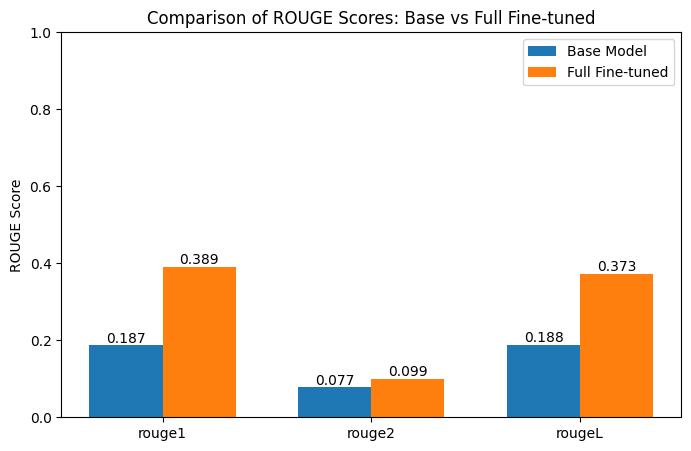

In [41]:

# --- Prepare data for plotting ---
metrics = ['rouge1', 'rouge2', 'rougeL']
base_scores = [base_model_results[m] for m in metrics]
ft_scores   = [finetuned_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

# --- Plot ---
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, base_scores, width, label='Base Model')
rects2 = ax.bar(x + width/2, ft_scores, width, label='Full Fine-tuned')

ax.set_ylabel('ROUGE Score')
ax.set_title('Comparison of ROUGE Scores: Base vs Full Fine-tuned')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.bar_label(rects1, fmt='%.3f')
ax.bar_label(rects2, fmt='%.3f')

plt.ylim(0, 1)
plt.show()


### Calculate the absolute improvement of the Full Fine-tuned Model over the Base Model

In [42]:
print("Absolute percentage improvement of Full Fine-tuned Model over Base Model:")

improvement = (np.array(list(finetuned_results.values())) - np.array(list(base_model_results.values())))
for key, value in zip(finetuned_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')


Absolute percentage improvement of Full Fine-tuned Model over Base Model:
rouge1: 20.29%
rouge2: 2.14%
rougeL: 18.53%
rougeLsum: 18.52%


In [43]:
import numpy as np

print("Percentage difference of Full Fine-tuned Model over Base Model (positive = gain, negative = loss)")

# Calculate the difference
improvement = np.array(list(finetuned_results.values())) - np.array(list(base_model_results.values()))

# Print with sign
for key, value in zip(finetuned_results.keys(), improvement):
    if value >= 0:
        print(f'{key}: +{value*100:.2f}% (gain)')
    else:
        print(f'{key}: {value*100:.2f}% (loss)')


Percentage difference of Full Fine-tuned Model over Base Model (positive = gain, negative = loss)
rouge1: +20.29% (gain)
rouge2: +2.14% (gain)
rougeL: +18.53% (gain)
rougeLsum: +18.52% (gain)
